In [3]:
# !pip install uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import uproot

In [4]:
file_path = "../../sim_first/build/plot_1e8.root"
file = uproot.open(file_path)

file['Photons'].keys()

time_ns = file['Photons']['fTime'].array(library='np')
energy_keV = file['Photons']['fEnergy'].array(library='np')/1000.
x_mm = file['Photons']['fX'].array(library='np')
y_mm = file['Photons']['fY'].array(library='np')
z_mm = file['Photons']['fZ'].array(library='np')

polX = file['Photons']['fPolX'].array(library='np')
polY = file['Photons']['fPolY'].array(library='np')
polZ= file['Photons']['fPolZ'].array(library='np')

eventID = file['Photons']['fEvent'].array(library='np')

We will do the same things we did in the more elaborate notebook, but with numpy only and being memory and time efficient.

In [5]:
energy_keV_blurred = np.random.normal(energy_keV, 0.1*energy_keV)

In [6]:
#sort the time_ns array and then rearrange all the other arrays in the same way

time_ns_sorted_index = np.argsort(time_ns)
time_ns = time_ns[time_ns_sorted_index]
energy_keV = energy_keV[time_ns_sorted_index]
energy_keV_blurred = energy_keV_blurred[time_ns_sorted_index]
x_mm = x_mm[time_ns_sorted_index]
y_mm = y_mm[time_ns_sorted_index]
z_mm = z_mm[time_ns_sorted_index]
polX = polX[time_ns_sorted_index]
polY = polY[time_ns_sorted_index]
polZ = polZ[time_ns_sorted_index]
eventID = eventID[time_ns_sorted_index]

In [7]:
def angle_between_vectors(v1, v2):
    #v1 and v2 are arrays of shape (3,)
    #returns a float

    return np.arccos(np.sum(v1*v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))


def vectorized_angle_between_vectors(v1_array, v2_array):
    #v1 and v2 are arrays of shape (n, 3)
    #returns an array of shape (n, 1)

    return np.arccos(np.sum(v1_array*v2_array, axis=1)/(np.linalg.norm(v1_array, axis=1)*np.linalg.norm(v2_array, axis=1)))

def vectorized_normaldotprod_between_vectors(v1_array, v2_array):
    #v1 and v2 are arrays of shape (n, 3)
    #returns an array of shape (n, 1)

    return np.sum(v1_array*v2_array, axis=1)/(np.linalg.norm(v1_array, axis=1)*np.linalg.norm(v2_array, axis=1))


In [8]:
# def time_window_filter(time_ns : np.array, window_ns):
#     coincidences = []
#     for i in range(len(time_ns)):
#         temp_coincidences = []
#         j = i + 1
#         while j < len(time_ns) and abs(time_ns[i] - time_ns[j]) < window_ns:
#             temp_coincidences.append((i, j))
#             j += 1
#         if len(temp_coincidences) == 1:
#             coincidences += temp_coincidences
#     return coincidences

In [9]:
# def time_window_filter(time_ns : np.array, window_ns):
#     coincidences = []
#     event_count = len(time_ns)
#     i = 0
#     while i < event_count:
#         temp_coincidences = []
#         j = i + 1
#         while j < event_count and abs(time_ns[j] - time_ns[i]) < window_ns:
#             temp_coincidences.append((i, j))
#             j += 1
#         if len(temp_coincidences) == 1:
#             coincidences.append(temp_coincidences[0])
#         i = j
        
#     return coincidences

In [10]:
# def time_window_filter(time_ns : np.array, window_ns):
#     coincidences = []
#     for i in range(len(time_ns)):
#         temp_coincidences = []
#         j = i + 1
#         while j < len(time_ns) and abs(time_ns[i] - time_ns[j]) < window_ns:
#             temp_coincidences.append((i, j))
#             j += 1
#         if len(temp_coincidences) == 1:
#             coincidences.append(temp_coincidences[0])
#     return coincidences

In [11]:
def time_window_filter(time_ns : np.array, window_ns):
    coincidences = []
    for i in range(len(time_ns)):
        temp_coincidences = []
        j = i + 1
        while j < len(time_ns) and abs(time_ns[i] - time_ns[j]) < window_ns:
            temp_coincidences.append((i, j))
            j += 1
        coincidences += temp_coincidences
    return coincidences

In [12]:
def energy_filter(coincidences, energy_keV_blurred, energy_keV_min, energy_keV_max):
    #so the coincidence array has shape (n, 2)
    #we want to filter out the rows where the energy of both events is not in the specified range

    #we will do this by first creating a boolean array of shape (n, 2) where
    # the value is True if the energy is in the specified range
    #and then we will check if both values in the row are True
    #this will give us a boolean array of shape (n, 1)
    #we will then use this array to index the coincidence array and get the filtered coincidences

    #create the boolean array
    bool_array = np.array([(energy_keV_min < energy_keV_blurred[coincidences[:, 0]]) \
         & (energy_keV_blurred[coincidences[:, 0]] < energy_keV_max), \
            (energy_keV_min < energy_keV_blurred[coincidences[:, 1]]) \
         & (energy_keV_blurred[coincidences[:, 1]] < energy_keV_max)])
    bool_array = np.transpose(bool_array)

    #check if both values in the row are True
    bool_array = np.all(bool_array, axis=1)

    #index the coincidence array
    filtered_coincidences = coincidences[bool_array]

    return filtered_coincidences

In [13]:
time_window_coincidences = time_window_filter(time_ns, 4)

In [14]:
time_window_coincidences = np.array(time_window_coincidences)


In [15]:
energy_coincidences = energy_filter(time_window_coincidences, energy_keV_blurred, 350.0, 650.0)

In [16]:
len(energy_coincidences), len(time_window_coincidences) #energy coincidences may or may not be true coincidences!

(9865510, 11758854)

In [17]:
def count_true_in_filtered_coincidences(eventID, coincidences):
    coincidences = np.array(coincidences)
    cond1 = (eventID[coincidences[:, 0]] == eventID[coincidences[:, 1]])
    #condition 2 is that te events should be roughly diametrically opposite
    #we will use the dot product of the polarisation vectors to check this
    #the dot product of two vectors is 1 if they are parallel, -1 if they are anti-parallel and 0 if they are perpendicular
    #so we will check if the dot product is less than -0.9
    v1 = np.array([x_mm[coincidences[:, 0]], y_mm[coincidences[:, 0]], z_mm[coincidences[:, 0]]]).T
    v2 = np.array([x_mm[coincidences[:, 1]], y_mm[coincidences[:, 1]], z_mm[coincidences[:, 1]]]).T
    cond2 = (vectorized_normaldotprod_between_vectors(v1, v2) < -0.9)
    return np.sum(cond1 & cond2)

In [18]:
true_in_energy_filtered_count = count_true_in_filtered_coincidences(eventID, energy_coincidences)
total_in_energy_filtered_count = len(energy_coincidences)

In [19]:
true_in_energy_filtered_count, total_in_energy_filtered_count

(8389557, 9865510)

In [20]:
polX_1 = polX[time_window_coincidences[:, 0]]
polY_1 = polY[time_window_coincidences[:, 0]]
polZ_1 = polZ[time_window_coincidences[:, 0]]

polX_2 = polX[time_window_coincidences[:, 1]]
polY_2 = polY[time_window_coincidences[:, 1]]
polZ_2 = polZ[time_window_coincidences[:, 1]]

v1 = np.array([polX_1, polY_1, polZ_1]).T
v2 = np.array([polX_2, polY_2, polZ_2]).T

pol_angle_diff = vectorized_angle_between_vectors(v1, v2)

/var/folders/t0/kz8yxky97yg56bbdw_h8qs100000gn/T/ipykernel_931/3578568498.py:12: RuntimeWarning: invalid value encountered in divide
  return np.arccos(np.sum(v1_array*v2_array, axis=1)/(np.linalg.norm(v1_array, axis=1)*np.linalg.norm(v2_array, axis=1)))


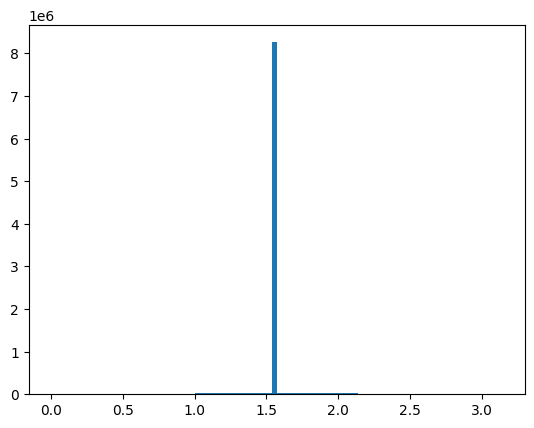

In [21]:
plt.hist(pol_angle_diff, bins=100)
plt.show()

In [22]:
pol_angle_diff_blurred = np.random.normal(pol_angle_diff, 0.1*np.abs(pol_angle_diff))

In [23]:
#get number of nan values in pol_angle_diff_blurred
np.sum(np.isnan(pol_angle_diff_blurred)), len(pol_angle_diff_blurred)

(2064174, 11758854)

In [24]:
len(time_window_coincidences), len(pol_angle_diff_blurred)

(11758854, 11758854)

In [25]:
def polarization_filter(coincidences, pol_angle_diff_blurred, angle_diff_min, angle_diff_max):
    bool_array = (pol_angle_diff_blurred > angle_diff_min) & (pol_angle_diff_blurred < angle_diff_max)
    return coincidences[bool_array]

In [26]:
polarization_coincidences = polarization_filter(time_window_coincidences, pol_angle_diff_blurred, 1.075, 2.000)

In [27]:
true_in_polarization_filtered_count = count_true_in_filtered_coincidences(eventID, polarization_coincidences)
total_in_polarization_filtered_count = len(polarization_coincidences)

In [28]:
true_in_polarization_filtered_count, total_in_polarization_filtered_count

(8208698, 8792509)

In [29]:
len(x_mm), len(time_window_coincidences), len(energy_coincidences), len(polarization_coincidences)

(20215251, 11758854, 9865510, 8792509)

In [30]:
true_in_energy_filtered_count, total_in_energy_filtered_count

(8389557, 9865510)

In [31]:
true_in_polarization_filtered_count, total_in_polarization_filtered_count

(8208698, 8792509)

In [32]:
count_true_in_filtered_coincidences(eventID, time_window_coincidences)

9172416